In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Graficar experimento 1

In [21]:
resultados_df_1 = pd.read_excel('Results/Experimento1[04_08_2023-19_47].xlsx')

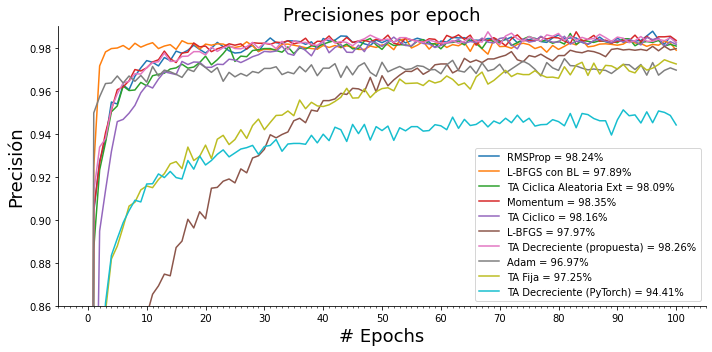

In [22]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df_1.index:
    if(resultados_df_1.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_1.loc[k1,'val_acc_list'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name} = {acc}%'.format(name= resultados_df_1.loc[k1,'name'],
                                        acc = round(lista[-1] * 100 , 2)))

plt.title('Precisiones por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.86, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.tight_layout()
plt.show()

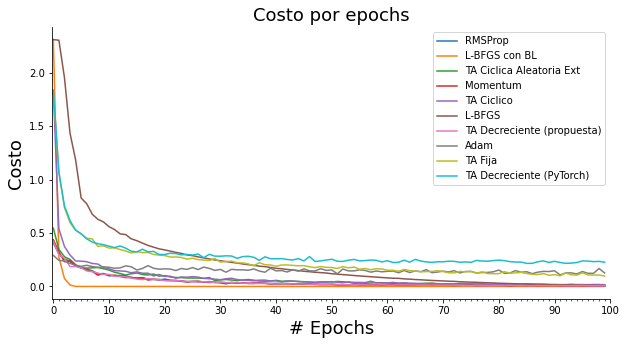

In [23]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df_1.index:
    if(resultados_df_1.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_1.loc[k1,'cost'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name}'.format(name= resultados_df_1.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_xlim([-0.2, 100])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

# Graficar experimento 2

In [24]:
resultados_df_2 = pd.read_excel('Results/Experimento2[04_08_2023-20_42].xlsx')

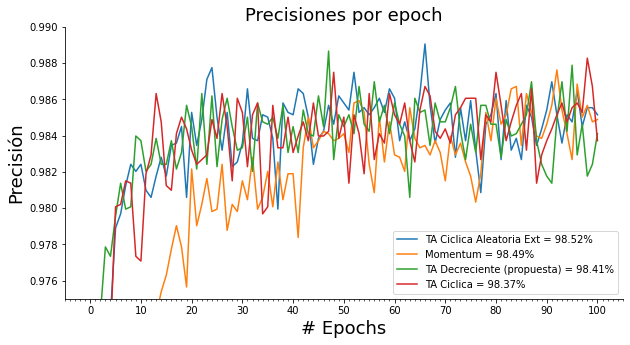

In [25]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df_2.index:
    if(resultados_df_2.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_2.loc[k1,'val_acc_list'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name} = {acc}%'.format(name= resultados_df_2.loc[k1,'name'],
                                        acc = round(lista[-1] * 100 , 2)))

plt.title('Precisiones por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.975, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.show()

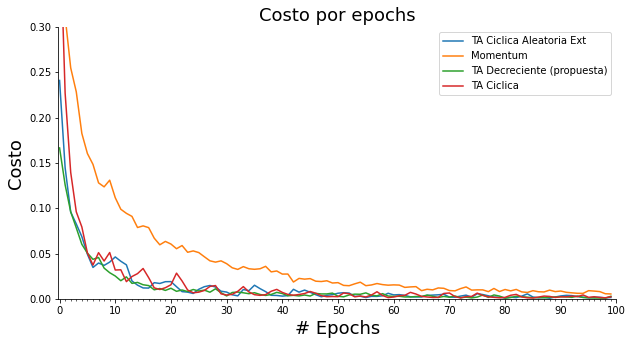

In [26]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df_2.index:
    if(resultados_df_2.loc[k1,'name'] not in ["TA Ciclica Aleatoria Decreciente", "TA Ciclica Aleatoria"]):
        lista = [float(x) for x in eval(resultados_df_2.loc[k1,'cost'])]
        ax.plot(range(len(lista)),
            lista,
            label='{name}'.format(name= resultados_df_2.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_ylim([0, 0.3])
ax.set_xlim([-0.2, 100])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

# ResNet Graphs

In [27]:
EPOCHS = 50
MAX_ITERATIONS = 5
resultados = {}

In [28]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda x: x != 0, dic_list))

In [29]:
def SummarizeResults(result_df: pd.DataFrame, filterStr: str, resultados: dict):
    
    if(filterStr not in resultados):
        resultados[filterStr] = {}
        resultados[filterStr]['val_acc_list'] = [0] * EPOCHS
        resultados[filterStr]['test_acc'] = 0
        resultados[filterStr]['cost'] = [0] * EPOCHS
        resultados[filterStr]['time'] = 0
        resultados[filterStr]['epochs'] = 0

    lr_list = []
    for k1 in result_df.index:
        if(result_df.loc[k1,'name'] == filterStr):

            val_acc_list = [float(x) for x in eval(result_df.loc[k1,'val_acc_list'])]
            acc = (float(result_df.loc[k1,'test_acc'].strip('%')))/100
            cost_list = [float(x) for x in eval(result_df.loc[k1,'cost'])]
            time = result_df.loc[k1,'time']
            epochs = result_df.loc[k1,'epochs']
            lr_list = result_df.loc[k1, 'lr']

            resultados[filterStr]['val_acc_list'] = SumList(resultados[filterStr]['val_acc_list'], val_acc_list)
            resultados[filterStr]['test_acc'] += acc
            resultados[filterStr]['cost'] = SumList(resultados[filterStr]['cost'], cost_list)
            resultados[filterStr]['time'] += time
            resultados[filterStr]['epochs'] += epochs
            resultados[filterStr]['lr'] = lr_list

In [30]:
def AverageResults(filterStr: str, resultados: dict):
    
    resultados[filterStr]['name'] = filterStr
    resultados[filterStr]['test_acc'] = resultados[filterStr]['test_acc'] / MAX_ITERATIONS
    resultados[filterStr]['val_acc_list'] = DeleteZerosFromList(DivideList(resultados[filterStr]['val_acc_list'], MAX_ITERATIONS))
    resultados[filterStr]['cost'] = DeleteZerosFromList(DivideList(resultados[filterStr]['cost'], MAX_ITERATIONS))
    resultados[filterStr]['time'] = resultados[filterStr]['time']/ MAX_ITERATIONS
    resultados[filterStr]['epochs'] = resultados[filterStr]['epochs'] / MAX_ITERATIONS

In [31]:
resultados_df_ex1 = pd.read_excel('Results/Experimento3[04_15_2023-15_01].xlsx')
resultados_df_ex2 = pd.read_excel('Results/Experimento3[04_15_2023-20_41].xlsx')
resultados_df_ex3 = pd.read_excel('Results/Experimento3[04_16_2023-11_28].xlsx')
resultados_df_ex4 = pd.read_excel('Results/Experimento3[04_16_2023-15_16].xlsx')
resultados_df_ex5 = pd.read_excel('Results/Experimento3[04_17_2023-18_36].xlsx')

In [32]:
dfs = [resultados_df_ex1, resultados_df_ex2, resultados_df_ex3, resultados_df_ex4, resultados_df_ex5]
filters = ['TA Ciclica Aleatoria Ext', 'Adam', 'TA Decreciente (propuesta)']

In [33]:
for df in dfs:
    for filterStr in filters:
        SummarizeResults(result_df = df, filterStr = filterStr, resultados = resultados)

for filterStr in filters:
    AverageResults(filterStr=filterStr, resultados=resultados)


In [34]:
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

In [35]:
resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)
resultados_df[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30220\1229857557.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
TA Ciclica Aleatoria Ext,0.000000,2589420.350000
Adam,0.000000,2742108.050000
TA Decreciente (propuesta),0.000000,2139775.200000


In [36]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_30220\4194298493.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
TA Ciclica Aleatoria Ext,86.46%,2589420.350000,86.64%,0.000000
Adam,85.58%,2742108.050000,85.95%,0.000000
TA Decreciente (propuesta),60.72%,2139775.200000,60.31%,0.000000


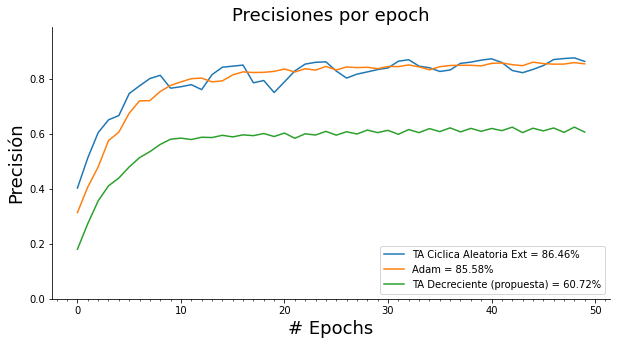

In [37]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                    acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Precisiones por epoch', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0, 0.990])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Precisión', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)
plt.show()

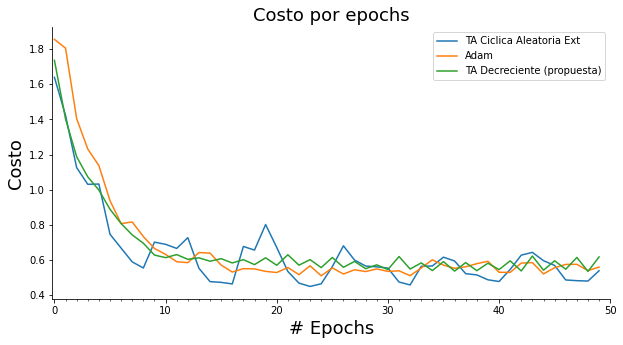

In [38]:
bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))

for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name}'.format(name= resultados_df.loc[k1,'name']))

plt.title('Costo por epochs', fontsize = 18)

ax.set_xlim([-0.2, 50])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()